In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
dataset = pd.read_csv(
    'raw.csv',
    parse_dates=[['year', 'month', 'day', 'hour']],
    index_col=0,
    date_parser=parse
)

In [4]:
dataset.head(10)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [5]:
dataset.drop('No', axis=1, inplace=True)

In [6]:
dataset.columns = [
    'pollution',
    'dew',
    'temp',
    'press',
    'wnd_dir',
    'wnd_spd',
    'snow',
    'rain'
]

dataset.index.name = 'date'

In [7]:
dataset['pollution'].fillna(0, inplace=True)

In [8]:
dataset = dataset[24:]

In [9]:
dataset.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [10]:
dataset.to_csv('pollution.csv')

In [13]:
data = pd.read_csv('pollution.csv', header=0, index_col=0)
data.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [19]:
values = data.values

groups = [0, 1, 2, 3, 5, 6, 7]

i = 1

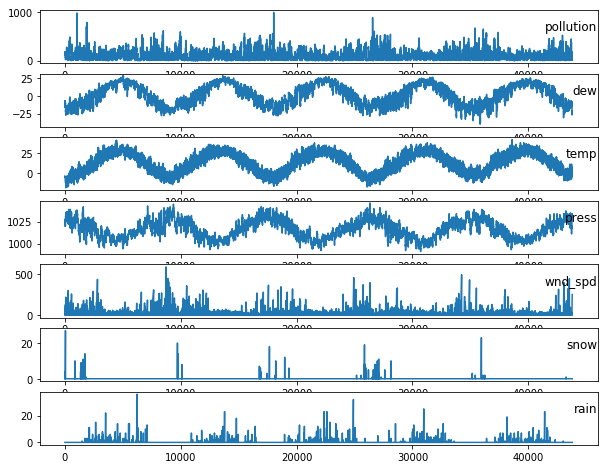

In [20]:
plt.figure(figsize=(10,8))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
labelEncoder = LabelEncoder()
data.iloc[:,4] = labelEncoder.fit_transform(data.iloc[:,4])
values = data.values
print(values.shape)
values = values.astype('float32')

(43800, 8)


In [23]:
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [24]:
series_to_supervised(values,1,1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.790000,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.680000,0.0,0.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.680000,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.570000,0.0,0.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.570000,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.360000,1.0,0.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.360000,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.250000,2.0,0.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.250000,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.140000,3.0,0.0
6,109.0,-7.0,-6.0,1022.0,2.0,7.140000,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.930000,4.0,0.0
7,105.0,-7.0,-6.0,1023.0,2.0,8.930000,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.720000,0.0,0.0
8,124.0,-7.0,-5.0,1024.0,2.0,10.720000,0.0,0.0,120.0,-8.0,-6.0,1024.0,2.0,12.510000,0.0,0.0
9,120.0,-8.0,-6.0,1024.0,2.0,12.510000,0.0,0.0,132.0,-7.0,-5.0,1025.0,2.0,14.300000,0.0,0.0
10,132.0,-7.0,-5.0,1025.0,2.0,14.300000,0.0,0.0,140.0,-7.0,-5.0,1026.0,2.0,17.430000,1.0,0.0


In [25]:
reframed = series_to_supervised(values,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0


In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [27]:
values = reframed.values
n_train = 365*24
train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

In [28]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


In [29]:
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [31]:
print(trainX.shape)
print(testX.shape)

(8760, 1, 8)
(35039, 1, 8)


In [32]:
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), dropout=0.2))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:
history = model.fit(
    trainX,
    trainY,
    validation_data=(testX, testY),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35039 samples
Epoch 1/100
 - 3s - loss: 0.0531 - val_loss: 0.0348
Epoch 2/100
 - 1s - loss: 0.0336 - val_loss: 0.0219
Epoch 3/100
 - 1s - loss: 0.0315 - val_loss: 0.0201
Epoch 4/100
 - 1s - loss: 0.0305 - val_loss: 0.0200
Epoch 5/100
 - 1s - loss: 0.0306 - val_loss: 0.0196
Epoch 6/100
 - 1s - loss: 0.0290 - val_loss: 0.0198
Epoch 7/100
 - 1s - loss: 0.0300 - val_loss: 0.0205
Epoch 8/100
 - 1s - loss: 0.0308 - val_loss: 0.0196
Epoch 9/100
 - 1s - loss: 0.0302 - val_loss: 0.0196
Epoch 10/100
 - 1s - loss: 0.0289 - val_loss: 0.0194
Epoch 11/100
 - 1s - loss: 0.0292 - val_loss: 0.0195
Epoch 12/100
 - 1s - loss: 0.0286 - val_loss: 0.0189
Epoch 13/100
 - 1s - loss: 0.0292 - val_loss: 0.0194
Epoch 14/100
 - 1s - loss: 0.0288 - val_loss: 0.0192
Epoch 15/100
 - 1s - loss: 0.0283 - val_loss: 0.0190
Epoch 16/100
 - 1s - loss: 0.0283 - val_loss: 0.0179
Epoch 17/100
 - 1s - loss: 0.0281 - val_loss: 0.0181
Epoch 18/10

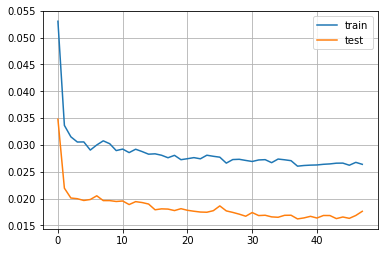

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
predicted = model.predict(testX)

In [36]:
testXRe = testX.reshape(testX.shape[0],testX.shape[2])

In [37]:
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

In [38]:
predicted.shape

(35039, 8)

In [39]:
predicted = scaler.inverse_transform(predicted)

In [40]:
testY = testY.reshape(len(testY), 1)

In [41]:
testY.shape

(35039, 1)

In [42]:
testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

In [43]:
testY = scaler.inverse_transform(testY)

In [44]:
pd.DataFrame(testY)

,0,1,2,3,4,5,6,7
0,31.0,-17.000000,-7.000000,1037.000000,1.0,75.099998,0.0,0.0
1,20.0,-17.000000,-7.000000,1037.000000,0.0,4.020000,0.0,0.0
2,19.0,-17.000000,-7.000000,1037.000000,0.0,8.940000,0.0,0.0
3,18.0,-18.000000,-8.000000,1037.000000,1.0,4.020000,0.0,0.0
4,17.0,-18.000000,-8.000000,1037.000000,0.0,4.020000,0.0,0.0
5,14.0,-18.000000,-7.000000,1037.000000,0.0,8.040000,0.0,0.0
6,14.0,-18.000000,-8.000000,1036.000000,1.0,4.920000,0.0,0.0
7,22.0,-18.000000,-8.000000,1037.000000,0.0,4.020000,0.0,0.0
8,22.0,-18.000000,-7.000000,1037.000000,0.0,8.940000,0.0,0.0
9,25.0,-18.000000,-6.000000,1038.000000,0.0,12.960000,0.0,0.0
